In [1]:
using Plots
pyplot(grid=false)
using LaTeXStrings
include("proxgrad.jl")

proxgrad_const (generic function with 1 method)

In [2]:
"""plot line w*x+b=0"""
function plotline!(w::Array{Float64,1},b::Number,
                  xmin::Number=-100,xmax::Number=100; 
                  kwargs...)
    x1samples = [xmin, xmax]
    # w[1]*x[1]+w[2]*x[2]+b = 0
    x2samples = (-b - w[1]*x1samples)/w[2]
    plot!(x1samples, x2samples; kwargs...)
end
# plotline!([1.,2.], 3, color="red", label="a line")

plotline!

In [3]:
# Generate and plot data
srand(5)
color = ["blue", "red", "cyan", "magenta"]
shape = [:circle, :diamond, :utriangle, :star5]
n = 20
function sample_data(num_points; noise=1)
    X1 = randn(n,2)*noise .+ [4 0]
    y1 = fill(1,n)
    X2 = randn(n,2)*noise .+ [-3 3]
    y2 = fill(2,n)
    X3 = randn(n,2)*noise .+ [-3 -3]
    y3 = fill(3,n)    
    return vcat(X1,X2,X3), vcat(y1,y2,y3)
end
X,y = sample_data(n)

([5.46431 -0.520668; 4.26087 1.16752; … ; -5.10819 -4.34591; -2.03411 -4.41537], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3])


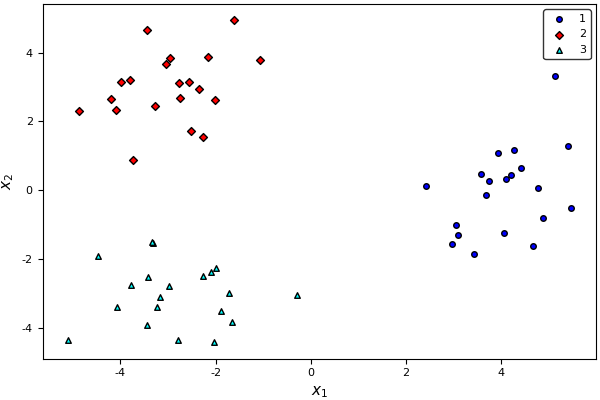

In [4]:
"""function to plot the above data"""
function plotdata(X=X,y=y; margin=.05)
    scatter(X[y.==1,1],X[y.==1,2], color=color[1], markershape=shape[1],label="1")
    scatter!(X[y.==2,1],X[y.==2,2], color=color[2], markershape=shape[2],label="2")
    scatter!(X[y.==3,1],X[y.==3,2], color=color[3], markershape=shape[3],label="3")            
    xlabel!(L"x_1")
    ylabel!(L"x_2")
    range_y = maximum(X[:,2]) - minimum(X[:,2])
    range_x = maximum(X[:,1]) - minimum(X[:,1])
    ylims!((minimum(X[:,2])-margin*range_y,maximum(X[:,2])+margin*range_y))
    xlims!((minimum(X[:,1])-margin*range_x,maximum(X[:,1])+margin*range_x))
end
plotdata()
# savefig("nominal_data.pdf")

In [5]:
function plot_imputed!(l::Loss, X, w, color, shape)
    yhat = impute([l], X*w)
    for l in sort(unique(yhat))
        scatter!(X[find(yhat.==l),1], X[find(yhat.==l),2], color=color[l], markershape=shape[l], alpha=.15, label="$l (imputed)")
    end
end

plot_imputed! (generic function with 1 method)

# One-vs-All Hinge Loss

In [6]:
n = length(y)
Xoffset = [X ones(n)]
loss = OvALoss(3, bin_loss = LogisticLoss())
scale!(loss, 1/n)
w_ova = proxgrad(loss, ZeroReg(), Xoffset, y, stepsize=1/norm(Xoffset)^2, maxiters=2000)

3×3 Array{Float64,2}:
  0.986984    -0.415751  -0.389007
  0.00880286   0.876913  -0.866182
 -0.177572    -0.353287  -0.376385


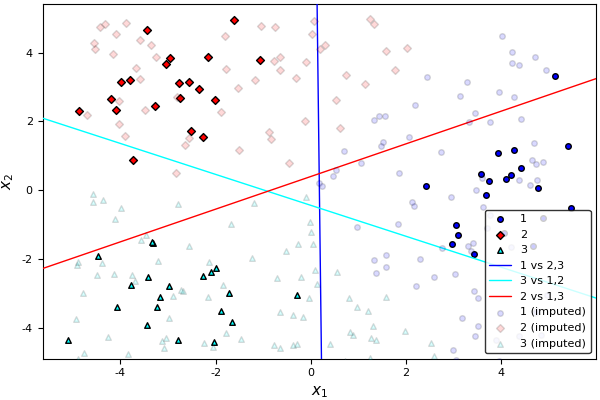

In [7]:
# plot the fit
p = plotdata()
plotline!(w_ova[1:2,1], w_ova[3,1]; label="1 vs 2,3", color=color[1])
plotline!(w_ova[1:2,3], w_ova[3,3]; label="3 vs 1,2", color=color[3])
plotline!(w_ova[1:2,2], w_ova[3,2]; label="2 vs 1,3", color=color[2])
ntest = 200
Xtest = [10*rand(ntest,2)-5 ones(ntest)]
plot_imputed!(loss, Xtest, w_ova, color, shape)
# savefig("ova.pdf")
p

# multinomial logit

In [8]:
Xoffset = [X ones(n)]
loss = MultinomialLoss(3)
scale!(loss, 1/n)
w_mnl = proxgrad(loss, ZeroReg(), Xoffset, y, stepsize=1, maxiters=200)

3×3 Array{Float64,2}:
 1.78402     -0.959858   -0.824164 
 0.00230755   1.65834    -1.66065  
 0.0369048    0.0229549  -0.0598597


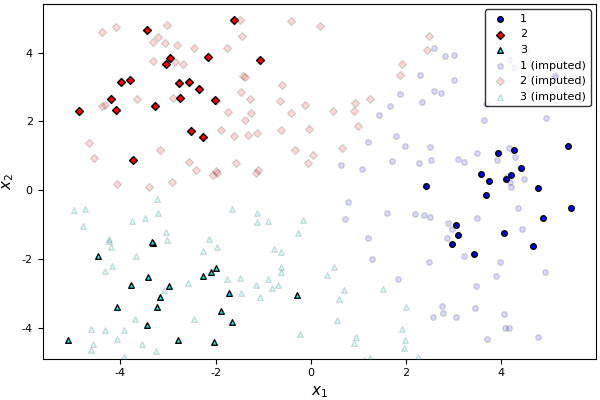

In [9]:
# plot the fit
p=plotdata()
ntest = 200
Xtest = [10*rand(ntest,2)-5 ones(ntest)]
plot_imputed!(loss, Xtest, w_mnl, color, shape)
# savefig("mnl.pdf")
p

# Ordinal data


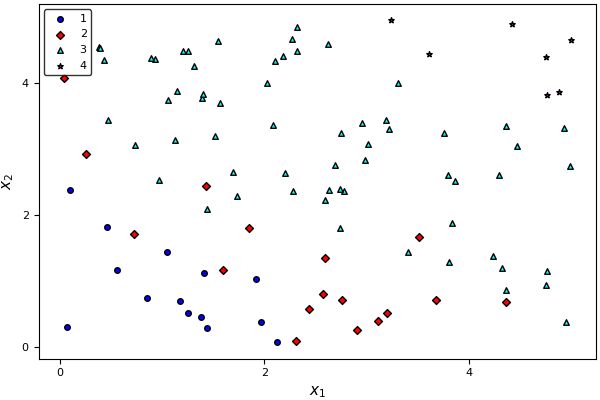

In [10]:
# Generate and plot data
srand(1)
n = 100
function sample_ord_data(num_points, num_levels; noise=.05)
    X = 5rand(num_points, 2)   
    w♮ = rand(2)
    z = X*w♮
    znorm = z - minimum(z)
    znorm = znorm / maximum(znorm)
    b = [.25, .4, .8]
    y = sum(znorm + noise*randn(num_points) .>= b', 2) + 1
    return X,vec(y)
end
X,y = sample_ord_data(n, 4)

"""function to plot the above data"""
function plot_ord_data(X=X,y=y; margin=.05)
    p=plot()
    for i=1:4
        scatter!(X[find(y.==i),1],X[find(y.==i),2], color=color[i], shape=shape[i], label="$i")
    end
    xlabel!(L"x_1")
    ylabel!(L"x_2")
    range_y = maximum(X[:,2]) - minimum(X[:,2])
    range_x = maximum(X[:,1]) - minimum(X[:,1])
    ylims!((minimum(X[:,2])-margin*range_y,maximum(X[:,2])+margin*range_y))
    xlims!((minimum(X[:,1])-margin*range_x,maximum(X[:,1])+margin*range_x))
    p
end
plot_ord_data()
# savefig("ord_data.pdf")

# Ordinal Hinge Loss

w_ordhinge = [0.445546, 0.50038, 0.274063]



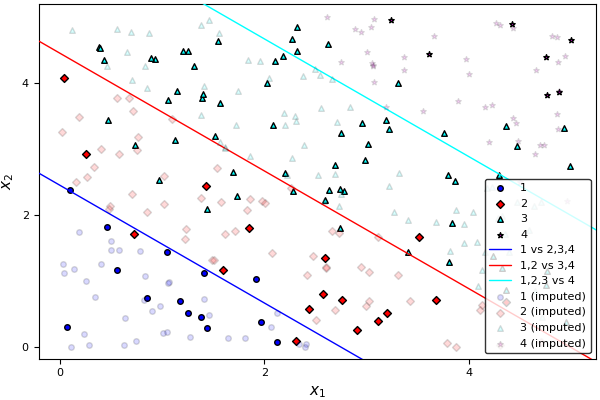

In [11]:
Xoffset = [X ones(n)]
loss = OrdinalHingeLoss(1,4)
scale!(loss, 1/n)
w_ordhinge = proxgrad(loss, ZeroReg(), Xoffset, y, stepsize=1, maxiters=200)
@show w_ordhinge

# plot the fit
p=plot_ord_data()
plotline!(w_ordhinge[1:2], w_ordhinge[3] - 1.5, color=color[1], label="1 vs 2,3,4")
plotline!(w_ordhinge[1:2], w_ordhinge[3] - 2.5, color=color[2], label="1,2 vs 3,4")
plotline!(w_ordhinge[1:2], w_ordhinge[3] - 3.5, color=color[3], label="1,2,3 vs 4")
ntest = 200
Xtest = [5*rand(ntest,2) ones(ntest)]
plot_imputed!(loss, Xtest, reshape(w_ordhinge, (3,1)), color, shape)
# savefig("ord_hinge.pdf")
p

In [12]:
# Bigger vs Smaller Loss

In [13]:
Xoffset = [X ones(n)]
loss = BvSLoss(4, bin_loss=LogisticLoss())
scale!(loss, 1/n)
w_bvs = proxgrad(loss, ZeroReg(), Xoffset, y, stepsize=1, maxiters=5000)
@show w_bvs

# plot the fit
p=plot_ord_data()
for i=1:3
    plotline!(w_bvs[1:2,i], w_bvs[3,i], color=color[i], label="<=$i vs >$i")
end
ntest = 200
Xtest = [5*rand(ntest,2) ones(ntest)]
plot_imputed!(loss, Xtest, w_bvs, color, shape)
# savefig("bvs_zeroreg.pdf")
p

w_bvs = [4.96305 2.44358 2.39082; 4.52139 3.80888 3.37804; -12.6342 -12.5941 -23.4466]


w_bvs = [2.44497 2.44497 2.44497; 3.29251 3.29251 3.29251; -7.39197 -11.5585 -23.2829]



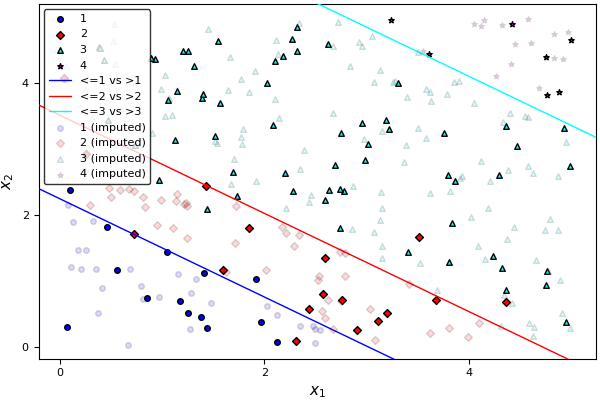

In [14]:
Xoffset = [X ones(n)]
loss = BvSLoss(4, bin_loss=LogisticLoss())
scale!(loss, 1/n)
w_bvs = proxgrad(loss, OrdinalReg(), Xoffset, y, stepsize=1, maxiters=5000)
@show w_bvs

# plot the fit
p=plot_ord_data()
for i=1:3
    plotline!(w_bvs[1:2,i], w_bvs[3,i], color=color[i], label="<=$i vs >$i")
end
ntest = 200
Xtest = [5*rand(ntest,2) ones(ntest)]
plot_imputed!(loss, Xtest, w_bvs, color, shape)
# savefig("bvs_ordinalreg.pdf")
p